In [37]:
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import nltk
import re
import pickle
import warnings

In [38]:
warnings.simplefilter("ignore")

# Prepare and Process Text
* Extract and merge brown corpus and gutenberg corpus from NLTK package.
* Convert word list to string.
* Process text: lower the text and remove unnecessary punctuation marks, spaces and numbers.
* Convert text to sentences list and convert each sentece into a word list.
* Remove all stopwords.

In [2]:
#Extract and merging brown and gutenberg corpuses

brown_corpus = nltk.corpus.brown.fileids()
gutenberg_corpus = nltk.corpus.gutenberg.fileids()

gutenberg_corpus = [nltk.corpus.gutenberg.raw(book) for book in gutenberg_corpus]
brown_corpus = [nltk.corpus.brown.words(paragraph) for paragraph in brown_corpus]

text = ''
for sentence in brown_corpus:
    for word in sentence:
        text += word + ' '
text = list(text)

corpus = gutenberg_corpus + text

In [3]:
#Convert word list to string

data = ''
for word in corpus:
    data += word + ' '

In [4]:
#Clean string text using regular expressions

text = data.lower()
text = re.sub(r'\[[0-9]*\]', ' ', text)
text = re.sub(r'\s+', ' ', text)
text = re.sub(r'\d', ' ', text)
text = re.sub(r'[^\w\s]', ' ', text)

In [5]:
#Convert string text to sentence and convert each sentence to a list of words

sentences = sent_tokenize(text)
sentences = [word_tokenize(sentence) for sentence in sentences]

In [6]:
#Remove stopwords (This can take ~10 mins)

for i in range(len(sentences)):
    sentences[i] = [word for word in sentences[i] if word not in stopwords.words('english')]

# Train Word2Vec Model
Once the text is processed, gensim package's Word2Vec model is going to be trained.

In [9]:
#Train gensim packages's Word2Vec model with the processed text

model = Word2Vec(sentences, min_count=1)

In [16]:
#Check number of words in the model's vocabulary

words = model.wv.vocab
print(len(words))

41615


In [18]:
#Find word's embedding values or vector

vector = model.wv['war']
print(vector)

[ 2.2157114e-02  7.9870149e-03  6.9162943e-03  1.0717741e-02
  2.3950754e-02  4.1246950e-03  3.9779032e-03  2.8060440e-02
  4.9122423e-03  3.1621307e-03 -6.9179670e-03 -3.3574112e-02
 -2.7364876e-02  7.2344276e-03 -3.5759006e-02  1.4120308e-02
 -6.8641661e-05  1.6547255e-02  6.8934849e-03 -1.6235597e-02
  5.0878253e-02 -1.7572077e-03  3.1873420e-02  3.9447449e-02
  2.1763567e-02  1.7144969e-02 -2.7481709e-02 -9.8319519e-03
 -2.4888210e-02  2.1724658e-02  2.9696137e-02  1.6956676e-02
  4.6684656e-02 -1.1046068e-02  1.6383760e-02 -2.9391266e-02
  4.0168217e-03  2.2273738e-02  4.1615713e-02 -9.8584860e-04
  4.6613980e-03  9.0672942e-03  1.8421059e-03  2.8120497e-02
 -5.3536285e-02  2.6065882e-02  1.8767200e-02  3.6644287e-02
 -1.6336428e-02  2.2407411e-02 -1.9293230e-02 -8.2657235e-03
  1.5004332e-02 -4.5636646e-02  3.2411136e-02 -5.1684785e-03
  1.1672002e-03  4.0606870e-03 -2.3365598e-02  2.5855803e-03
 -1.1600276e-02 -5.3729061e-03 -1.5380732e-02  6.3263311e-04
  1.2045000e-02  1.89098

In [20]:
#Most similar words

similar = model.wv.most_similar('school')
print(similar)

[('every', 0.9998589754104614), ('know', 0.9998558163642883), ('would', 0.9998493790626526), ('could', 0.9998472332954407), ('emma', 0.9998468160629272), ('mr', 0.9998465776443481), ('always', 0.9998462200164795), ('miss', 0.9998458027839661), ('harriet', 0.9998440742492676), ('good', 0.9998435378074646)]


# Visualize Word Embeddings using Word2Vec from Scratch
* Choose some target words
* Get the similar words of each one
* Apply PCA on their vectors to reduce the dimensionality from 100 dimensions to 3 dimensions
* Plot a customed interactive 3D scatter plot

In [33]:
target_words = ['father', 'dog', 'university', 'kidnap']

def plot_3D_embeddings(my_model, target_words, top_n_similars=6):
    class TooMuchWords(Exception):
        pass
    
    if len(target_words) > 5:
        raise TooMuchWords("You can only choose a maximum of 5 target words at a time.")
        
    similar_words = {}
    X = {}
    
    for target_word in target_words:
        similar_words[target_word] = list()
        similar = my_model.wv.most_similar(target_word, topn=top_n_similars)
        for i in range(len(similar)):
            similar_words[target_word].append(similar[i][0])
    
    for word in similar_words.keys():
        X[word] = list()
        X[word].append(my_model.wv[word])
        for word_similar in similar_words[word]:
            X[word].append(my_model.wv[word_similar])
    
    all_X = list()
    for word in X.keys():
        all_X += X[word]
    pca = PCA(n_components=3)
    all_X = pca.fit_transform(all_X)
    
    count = 0
    for word in similar_words.keys():
        num_words = len(similar_words[word])
        if count == 0:
            X[word] = all_X[:(num_words+1)]
        elif count > 0 and (len(similar_words.keys())-1) != count:
            X[word] = all_X[(num_words * count + count):(num_words * (count+1) + count+1)]
        else:
            X[word] = all_X[(num_words * count + count):]
        count += 1
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    
    markers = ['o','^', 's', '*', 'X']
    colors = list(mcolors.TABLEAU_COLORS)
    legend_elements = list()
    for i, word in enumerate(X.keys()):
        x = X[word][:, 0]
        y = X[word][:, 1]
        z = X[word][:, 2]
        
        if word in target_words:
            ax.scatter(x[0], y[0], z[0], marker=markers[i], c=colors[i], linewidths=2.0, edgecolors='black', s=200)
            legend_elements.append(Line2D([0], [0], marker=markers[i], color='w', label=word, markerfacecolor=colors[i], markersize=15))
            ax.text(x[0], y[0], z[0], word, bbox={'facecolor': 'white', 'alpha': 0.3, 'pad': 2})
        for j, similar_word in enumerate(similar_words[word]):
            ax.scatter(x[j+1], y[j+1], z[j+1], marker=markers[i], c=colors[i], s=60)
            ax.text(x[j+1], y[j+1], z[j+1], similar_word, bbox={'facecolor': 'white', 'alpha': 0.3, 'pad': 2})
            
    ax.legend(handles=legend_elements, loc='upper right')
    plt.title('Similar Words: 3D Visualization of Word Embeddings using PCA')
    

<IPython.core.display.Javascript object>


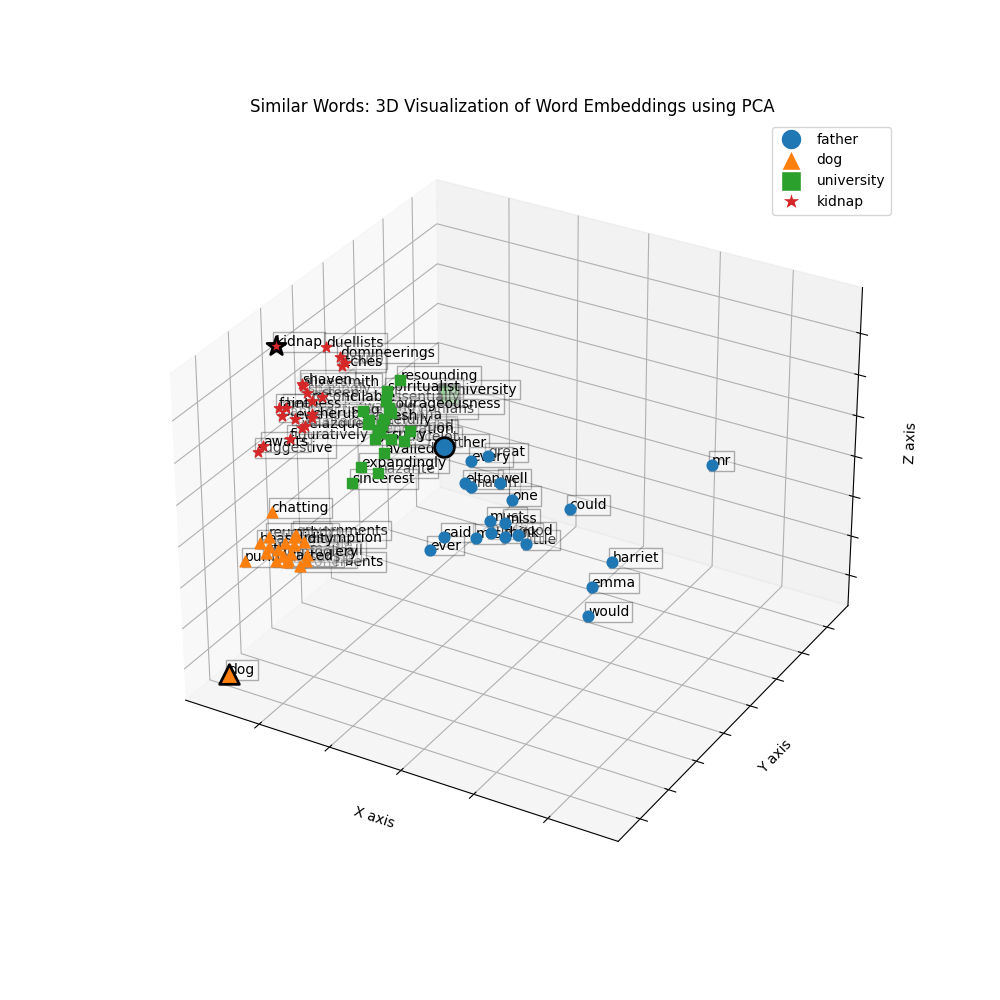

In [34]:
%matplotlib notebook
plot_3D_embeddings(model, target_words, top_n_similars=20)

# Use Pretrained Word2Vec
A pretrained Word2Vec model will be used. This pretrained model is trained over Wikipedia 2014 dataset and Gigaword 5 dataset. It has 6B tokens, 400K vocabulary words and 300 dimension vectors.

In [29]:
glove_file = datapath('/home/unai/Desktop/NLP/3 - Word2Vec/pretrained-word2vec/glove.6B.300d.txt')
word2vec_glove_file = get_tmpfile('glove.6B.300d.word2vec.txt')
glove2word2vec(glove_file, word2vec_glove_file)

pretrained_model = KeyedVectors.load_word2vec_format(word2vec_glove_file)

filename = 'glove2word2vec_model.sav'
pickle.dump(pretrained_model, open(filename, 'wb'))

# Available Pretrained Word2Vec Models
* Download a pretrained Word2Vec Model for visualizing its results in this repository: https://github.com/stanfordnlp/GloVe

![alt text](pretrained-word2vec-models.png "Pretrained Word2Vec Models")

<IPython.core.display.Javascript object>


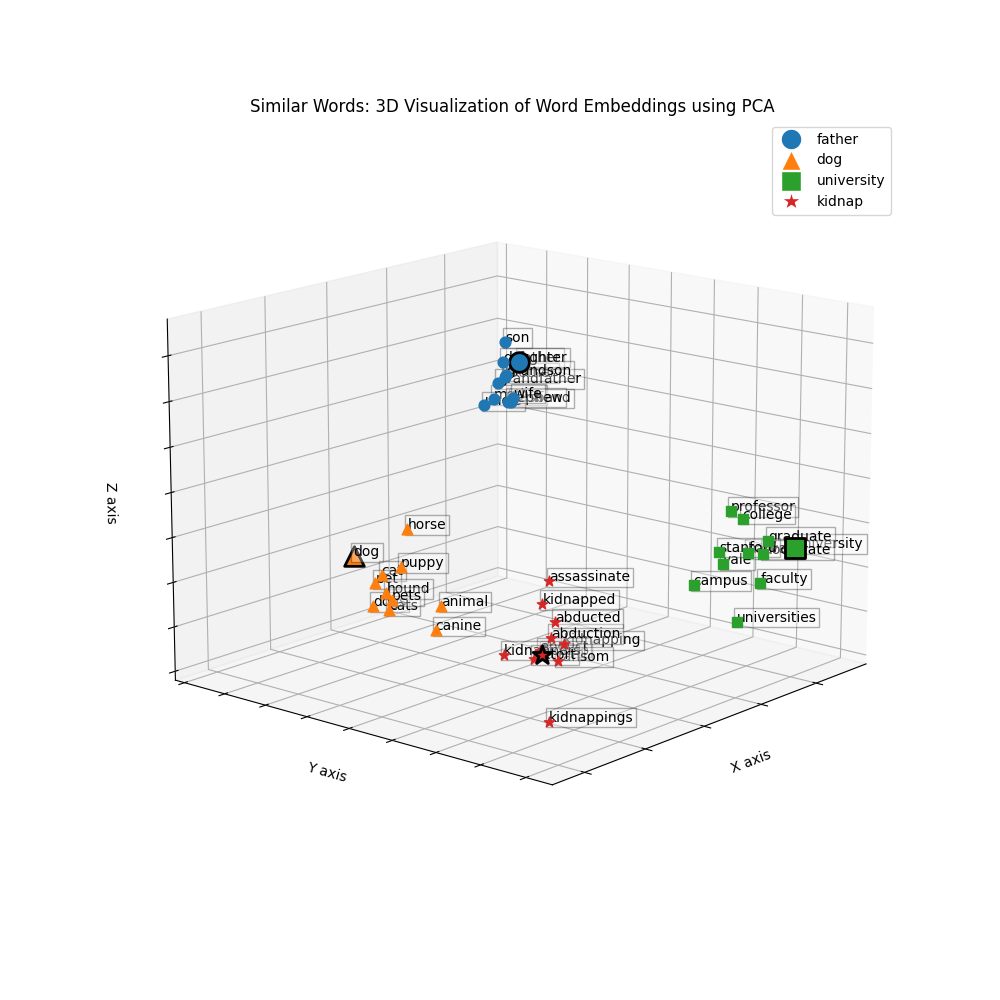

In [40]:
%matplotlib notebook
plot_3D_embeddings(pretrained_model, target_words, top_n_similars=10)